In [10]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [11]:
class LaneAttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(LaneAttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        attention = torch.sigmoid(self.conv1(x))
        x = self.conv2(x)
        x = x * attention
        return x

class EnhancedLaneATT(nn.Module):
    def __init__(self):
        super(EnhancedLaneATT, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.attention = LaneAttentionBlock(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 1, 3, stride=1, padding=1)  # Single channel for mask

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.attention(x)  # Apply attention block
        x = self.pool(F.relu(self.conv3(x)))
        x = self.conv4(x)  # Output without pooling
        return x

In [12]:
class LaneDataset(Dataset):
    def __init__(self, frames_dir, masks_dir, transform=None):
        self.frames_dir = frames_dir
        self.masks_dir = masks_dir
        self.transform_frame = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        self.transform_mask = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.frames = sorted(os.listdir(frames_dir))
        self.masks = sorted(os.listdir(masks_dir))
        assert len(self.frames) == len(self.masks), "Number of frames and masks should match"

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame_path = os.path.join(self.frames_dir, self.frames[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        frame = Image.open(frame_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Grayscale mask

        frame = self.transform_frame(frame)
        mask = self.transform_mask(mask)
        return frame, mask


In [18]:
# Set paths
frames_dir = r'C:\Users\Stephen Fernandes\Desktop\ProjEct\training\frames'
masks_dir = r'C:\Users\Stephen Fernandes\Desktop\ProjEct\training\lane-masks'

# Check paths
print("Frames directory exists:", os.path.exists(frames_dir))
print("Masks directory exists:", os.path.exists(masks_dir))
print("Number of frame files:", len(os.listdir(frames_dir)))
print("Number of mask files:", len(os.listdir(masks_dir)))

# Load dataset
dataset = LaneDataset(frames_dir, masks_dir)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Test dataset
test_dataset = LaneDataset(frames_dir, masks_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Frames directory exists: True
Masks directory exists: True
Number of frame files: 3626
Number of mask files: 3626


In [19]:
import os
print("Frames directory exists:", os.path.exists(frames_dir))
print("Masks directory exists:", os.path.exists(masks_dir))
print("Number of frame files:", len(os.listdir(frames_dir)))
print("Number of mask files:", len(os.listdir(masks_dir)))


Frames directory exists: True
Masks directory exists: True
Number of frame files: 3626
Number of mask files: 3626


In [22]:
# Dice Loss implementation
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        smooth = 1.0
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = EnhancedLaneATT().to(device)

# Define criterion with BCEWithLogitsLoss + DiceLoss
criterion = lambda outputs, masks: nn.BCEWithLogitsLoss()(outputs, masks) + DiceLoss()(outputs, masks)

# Define optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop with tqdm progress bar
from tqdm import tqdm

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Initialize tqdm progress bar
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")

    for batch_idx, (frames, masks) in progress_bar:
        frames, masks = frames.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        outputs = F.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update tqdm progress bar
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Using device: cuda


Epoch 1/20: 100%|███████████████████████████████████████████████████████| 227/227 [02:14<00:00,  1.69it/s, loss=1.0468]


Epoch [1/20], Loss: 1.0805


Epoch 2/20: 100%|███████████████████████████████████████████████████████| 227/227 [01:21<00:00,  2.80it/s, loss=0.9396]


Epoch [2/20], Loss: 0.9868


Epoch 3/20: 100%|███████████████████████████████████████████████████████| 227/227 [01:19<00:00,  2.84it/s, loss=0.9182]


Epoch [3/20], Loss: 0.9575


Epoch 4/20: 100%|███████████████████████████████████████████████████████| 227/227 [01:20<00:00,  2.82it/s, loss=0.9172]


Epoch [4/20], Loss: 0.9409


Epoch 5/20: 100%|███████████████████████████████████████████████████████| 227/227 [01:20<00:00,  2.82it/s, loss=0.9393]


Epoch [5/20], Loss: 0.9281


Epoch 6/20: 100%|███████████████████████████████████████████████████████| 227/227 [01:20<00:00,  2.83it/s, loss=0.8844]


Epoch [6/20], Loss: 0.9122


Epoch 7/20: 100%|███████████████████████████████████████████████████████| 227/227 [01:20<00:00,  2.83it/s, loss=0.8836]


Epoch [7/20], Loss: 0.9011


Epoch 8/20: 100%|███████████████████████████████████████████████████████| 227/227 [01:20<00:00,  2.82it/s, loss=0.9370]


Epoch [8/20], Loss: 0.9012


Epoch 9/20: 100%|███████████████████████████████████████████████████████| 227/227 [01:21<00:00,  2.77it/s, loss=0.8893]


Epoch [9/20], Loss: 0.8964


Epoch 10/20: 100%|██████████████████████████████████████████████████████| 227/227 [01:20<00:00,  2.81it/s, loss=0.8531]


Epoch [10/20], Loss: 0.8941


Epoch 11/20: 100%|██████████████████████████████████████████████████████| 227/227 [01:22<00:00,  2.74it/s, loss=0.8847]


Epoch [11/20], Loss: 0.8833


Epoch 12/20: 100%|██████████████████████████████████████████████████████| 227/227 [01:23<00:00,  2.73it/s, loss=0.8605]


Epoch [12/20], Loss: 0.8820


Epoch 13/20: 100%|██████████████████████████████████████████████████████| 227/227 [01:22<00:00,  2.77it/s, loss=0.8337]


Epoch [13/20], Loss: 0.8795


Epoch 14/20: 100%|██████████████████████████████████████████████████████| 227/227 [01:20<00:00,  2.81it/s, loss=0.8918]


Epoch [14/20], Loss: 0.8789


Epoch 15/20: 100%|██████████████████████████████████████████████████████| 227/227 [01:20<00:00,  2.81it/s, loss=0.8678]


Epoch [15/20], Loss: 0.8764


Epoch 16/20: 100%|██████████████████████████████████████████████████████| 227/227 [01:20<00:00,  2.82it/s, loss=0.8735]


Epoch [16/20], Loss: 0.8721


Epoch 17/20: 100%|██████████████████████████████████████████████████████| 227/227 [01:20<00:00,  2.83it/s, loss=0.8840]


Epoch [17/20], Loss: 0.8687


Epoch 18/20: 100%|██████████████████████████████████████████████████████| 227/227 [01:20<00:00,  2.82it/s, loss=0.7824]


Epoch [18/20], Loss: 0.8668


Epoch 19/20: 100%|██████████████████████████████████████████████████████| 227/227 [01:20<00:00,  2.84it/s, loss=0.8562]


Epoch [19/20], Loss: 0.8679


Epoch 20/20: 100%|██████████████████████████████████████████████████████| 227/227 [01:19<00:00,  2.84it/s, loss=0.8365]

Epoch [20/20], Loss: 0.8702


In [23]:
def visualize_predictions(model, test_loader):
    model.eval()

    with torch.no_grad():
        for i, (frames, masks) in enumerate(test_loader):
            frames = frames.to(device)
            masks = masks.to(device)

            outputs = model(frames)
            predictions = torch.sigmoid(outputs) > 0.5

            frames = frames.cpu().squeeze(0).permute(1, 2, 0).numpy()
            masks = masks.cpu().squeeze(0).squeeze(0).numpy()
            predictions = predictions.cpu().squeeze(0).squeeze(0).numpy()

            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(frames)
            plt.title("Original Frame")

            plt.subplot(1, 3, 2)
            plt.imshow(masks, cmap='gray')
            plt.title("Ground Truth Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions, cmap='gray')
            plt.title("Model Prediction")

            plt.show()

            if i == 5:  # Visualize up to 5 examples
                break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].


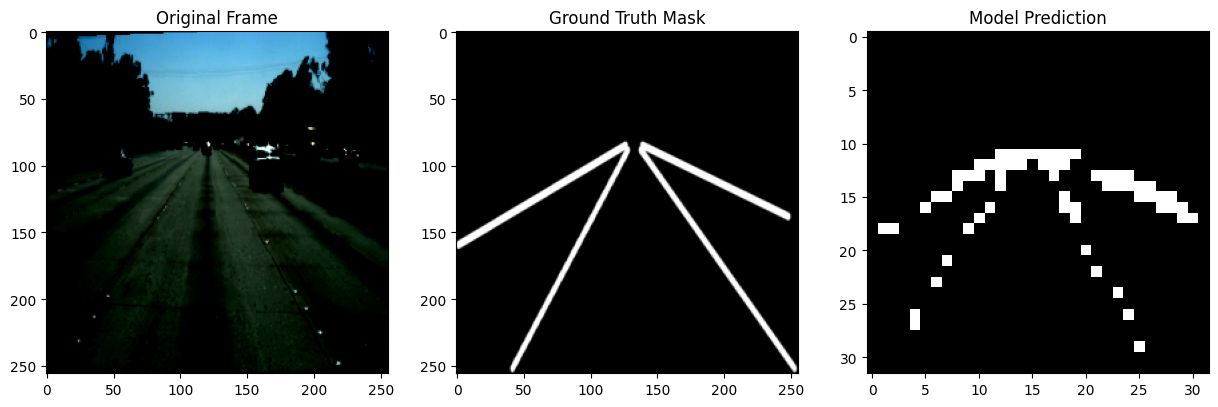

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].


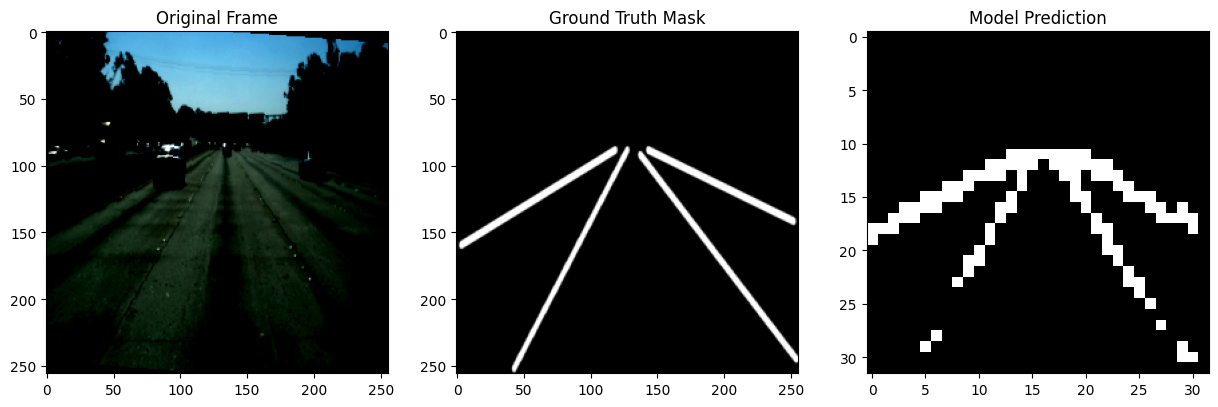

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..1.0].


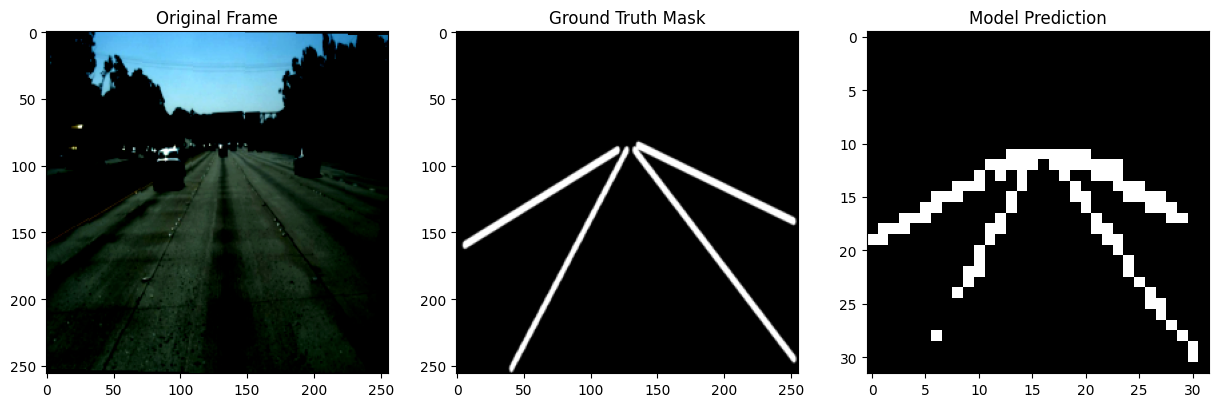

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].


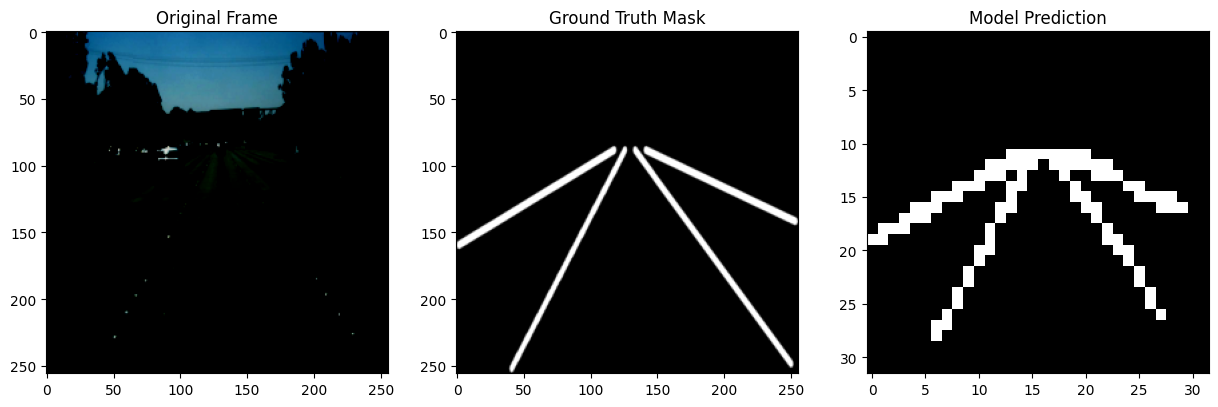

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.6784314].


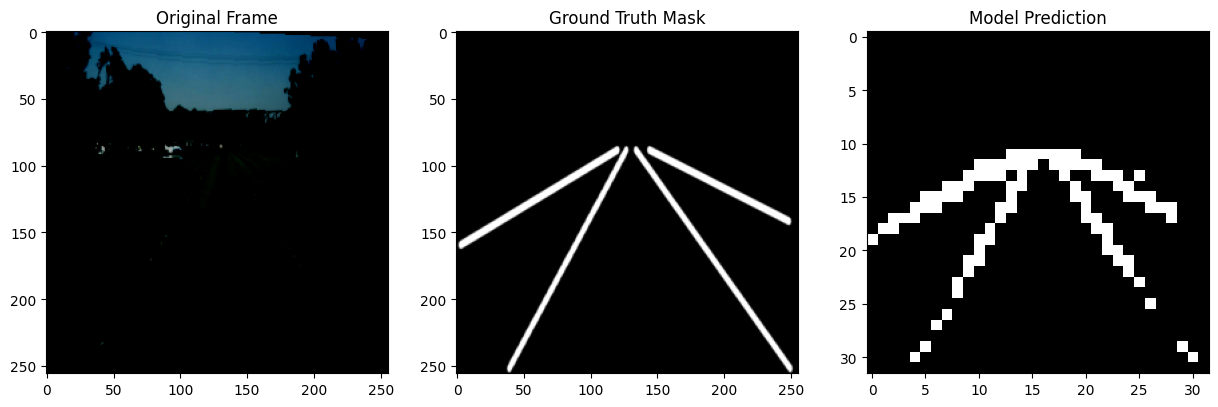

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.7176471].


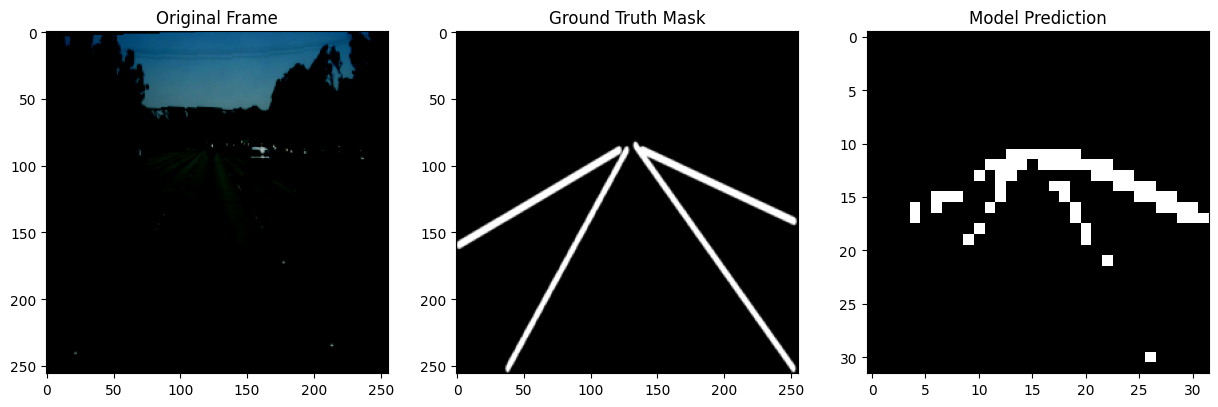

In [24]:
# Load test dataset (similar to training)
test_frames_dir = r'C:\Users\Stephen Fernandes\Desktop\ProjEct\training\frames'
test_masks_dir = r'C:\Users\Stephen Fernandes\Desktop\ProjEct\training\lane-masks'

test_dataset = LaneDataset(test_frames_dir, test_masks_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Visualize predictions
visualize_predictions(model, test_loader)


In [25]:
print(device)

cuda


In [26]:
pip install opencv-python opencv-contrib-python


   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   - -------------------------------------- 1.3/38.8 MB 6.1 MB/s eta 0:00:07
   --- ------------------------------------ 3.1/38.8 MB 7.1 MB/s eta 0:00:06
   ---- ----------------------------------- 4.2/38.8 MB 6.6 MB/s eta 0:00:06
   ----- ---------------------------------- 5.2/38.8 MB 6.1 MB/s eta 0:00:06
   ------ --------------------------------- 6.3/38.8 MB 5.9 MB/s eta 0:00:06
   ------- -------------------------------- 7.1/38.8 MB 5.8 MB/s eta 0:00:06
   ------- -------------------------------- 7.6/38.8 MB 5.3 MB/s eta 0:00:06
   -------- ------------------------------- 8.4/38.8 MB 4.9 MB/s eta 0:00:07
   --------- ------------------------------ 9.4/38.8 MB 5.0 MB/s eta 0:00:06
   ---------- ----------------------------- 10.5/38.8 MB 5.0 MB/s eta 0:00:06
   ------------ --------------------------- 11.8/38.8 MB 5.0 MB/s eta 0:00:06
   --------

In [74]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def post_process_predictions_with_hough(predictions, threshold=0.5):
    """
    Converts pixel-wise predictions to smooth, thin lines using Hough Transform.
    Args:
        predictions: Numpy array of predicted masks, shape (H, W).
        threshold: Threshold for binary mask conversion.
    Returns:
        Image with lane lines represented as smooth, thin lines.
    """
    # Step 1: Convert predictions to binary mask
    binary_mask = (predictions > threshold).astype(np.uint8)

    # Step 2: Apply edge detection to highlight lane boundaries
    edges = cv2.Canny(binary_mask, 50, 150)

    # Step 3: Use Hough Transform to detect lines
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=50, minLineLength=20, maxLineGap=15)

    # Step 4: Create an empty mask to draw the detected lines
    lane_lines = np.zeros_like(binary_mask)

    # Step 5: Draw each detected line
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lane_lines, (x1, y1), (x2, y2), 255, 1)  # Draw a thin line

    return lane_lines


def visualize_predictions_with_hough(model, test_loader, device, threshold=0.5):
    """
    Visualizes model predictions after post-processing with Hough Transform.
    Args:
        model: Trained lane detection model.
        test_loader: DataLoader for test dataset.
        device: Device (CPU or GPU).
        threshold: Threshold for binary mask conversion.
    """
    model.eval()
    with torch.no_grad():
        for i, (frames, masks) in enumerate(test_loader):
            frames, masks = frames.to(device), masks.to(device)

            outputs = model(frames)  # Get model predictions
            predictions = torch.sigmoid(outputs).cpu().numpy()  # Convert to NumPy array

            # Squeeze batch and channel dimensions
            predictions = np.squeeze(predictions, axis=(0, 1))  # (H, W)

            # Post-process predictions into smooth lines
            processed_predictions = post_process_predictions_with_hough(predictions, threshold=threshold)

            # Move tensors to CPU and prepare for visualization
            frames = frames.cpu().squeeze(0).permute(1, 2, 0).numpy()  # Convert to (H, W, C)
            masks = masks.cpu().squeeze(0).squeeze(0).numpy()  # Convert to (H, W)

            # Plot original frame, ground truth, and post-processed prediction
            plt.figure(figsize=(15, 5))

            # Plot original frame
            plt.subplot(1, 3, 1)
            plt.imshow(frames)
            plt.title("Original Frame")
            plt.axis('off')

            # Plot ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(masks, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Plot post-processed prediction
            plt.subplot(1, 3, 3)
            plt.imshow(processed_predictions, cmap='gray')
            plt.title("Post-Processed Prediction (Hough Lines)")
            plt.axis('off')

            # Display the plots
            plt.show()

            if i == 5:  # Visualize only the first 5 predictions
                break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


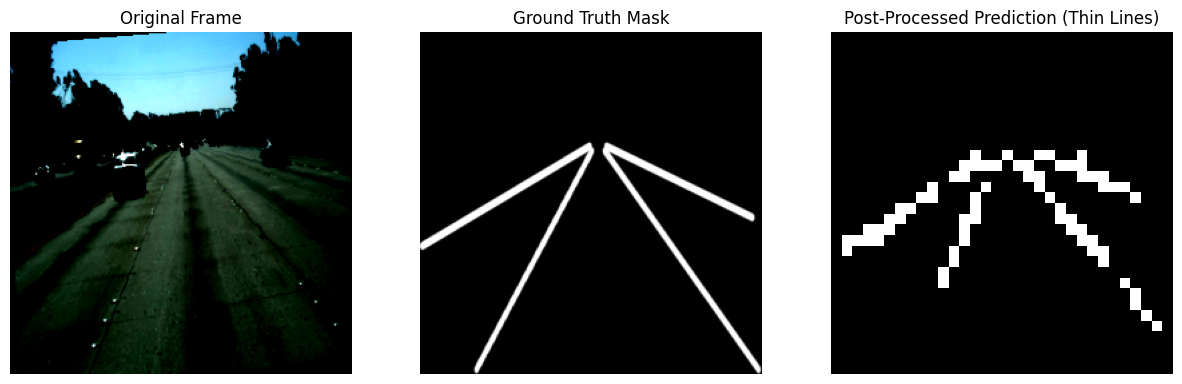

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.81960785].


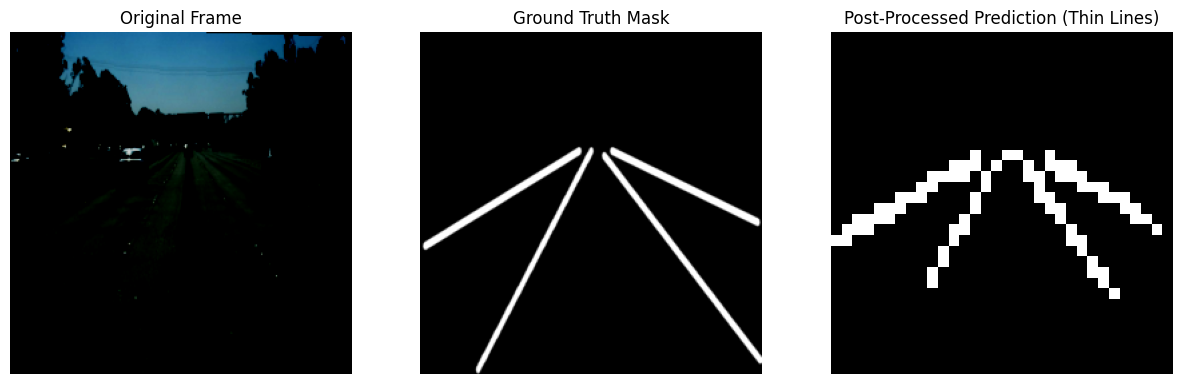

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..0.7647059].


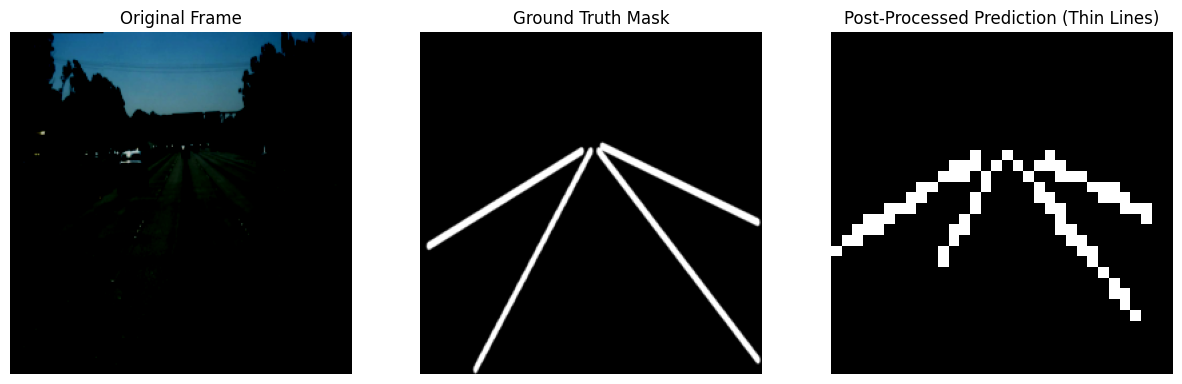

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.9607843].


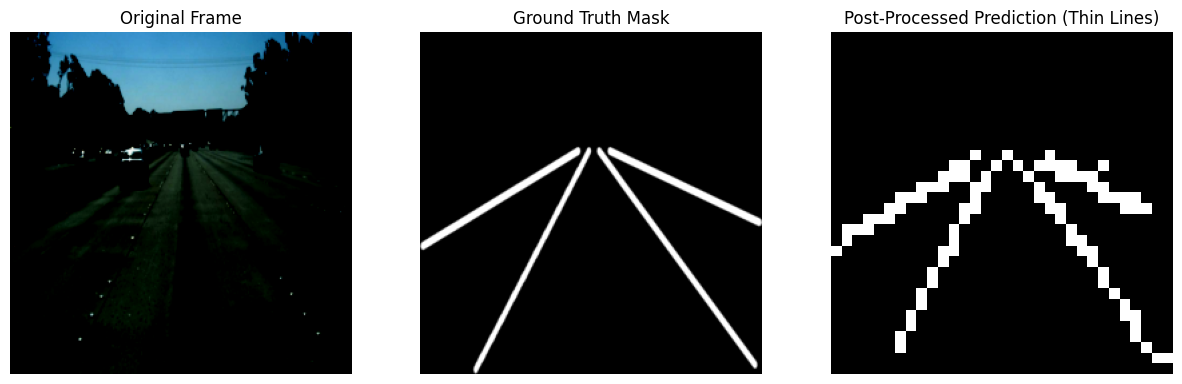

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


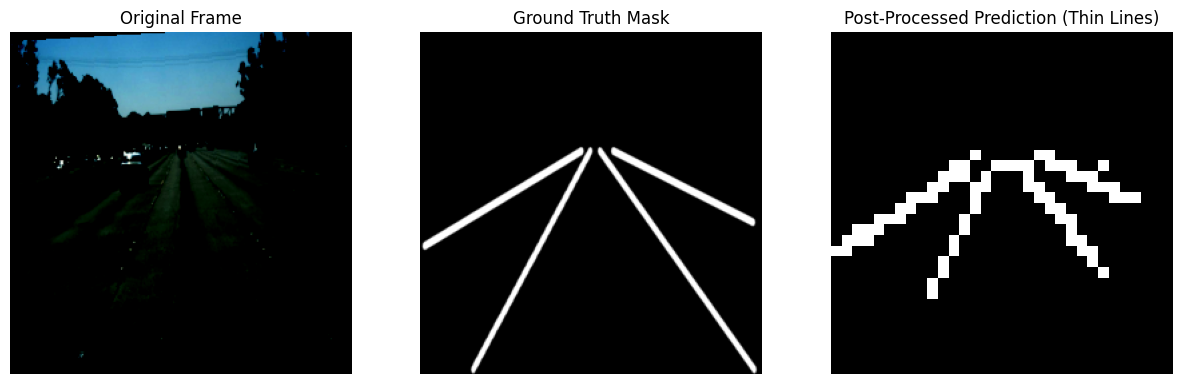

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.827451].


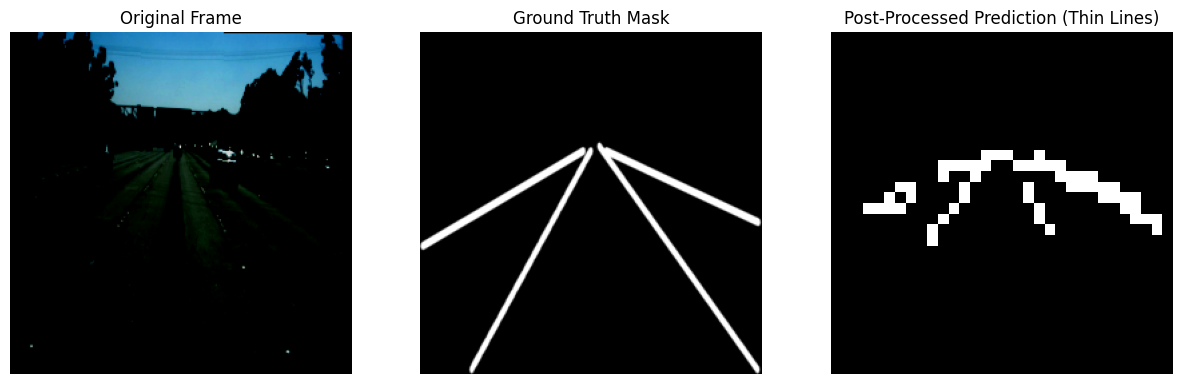

In [75]:
visualize_predictions_with_postprocessing(model, test_loader, device)


In [76]:
import torch

# Function to save the model
def save_model(model, path="lane_detection_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# After training, save the model
save_model(model, "lane_detection_model.pth")


Model saved to lane_detection_model.pth


In [77]:
import torch

# Function to load the model
def load_model(model, path="lane_detection_model.pth"):
    model.load_state_dict(torch.load(path))
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {path}")
    return model

# Initialize the model again
model = EnhancedLaneATT().to(device)

# Load the saved weights
model = load_model(model, "lane_detection_model.pth")

# Now you can use this model for predictions


Model loaded from lane_detection_model.pth


C:\Users\Stephen Fernandes\AppData\Local\Temp\ipykernel_2044\43522105.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))
